In [40]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### First task: load the required data and match up the catalogues

In [ ]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
gz2_stats = Table.read('fits/gz2_statistics.fits')
sparcfire_matched = Table.read('fits/galaxy_level_matched.fits')
ml_table_matched = Table.read('fits/ml_table_matched.fits')

In [19]:
sample_ok = ml_table_matched['vmax_ok']
sparcfire_ok = sparcfire_matched['N_arcs'] > 0
print('{} in initial sample --> {} in sparcfire'.format(sample_ok.sum(),
                                         (sample_ok*sparcfire_ok).sum()))

sparcfire_sample_ok = np.all([sparcfire_ok,sample_ok],axis=0)

5688 in initial sample --> 2759 in sparcfire


In [27]:
gz2_stats['p_bar'] = gz2_data['t03_bar_a06_bar_debiased_rh']
# define some classes:
# 1 = m=2, unbarred
# 2 = m=2, barred
# 3 = m>2, unbarred
# 4 = m>2, barred

plot_class = np.zeros(len(gz2_stats))
plot_class[(gz2_stats['m'] == 2) 
         & (gz2_stats['p_bar'] < 0.5)] = 1
plot_class[(gz2_stats['m'] == 2) 
         & (gz2_stats['p_bar'] >= 0.5)] = 2
plot_class[(gz2_stats['m'] > 2) 
         & (gz2_stats['p_bar'] < 0.5)] = 3
plot_class[(gz2_stats['m'] > 2) 
         & (gz2_stats['p_bar'] >= 0.5)] = 4

gz2_stats['plot_class'] = plot_class

#### First task: what do the pitch angle distributions _look_ like?

In [31]:
# Get some galaxy distributions to compare to

s4g_galaxies = Table.read('../fits/S4G/s4g_arms_galaxy.fits')
s4g_psi = np.array(s4g_galaxies['P_abs'])

seigar_06 = [8.4,25.2,25.7,18,26.4,46.4,17.6,31.1,15.7,50.3,31.7,48.8,42.1,
             20.3,26.4,46.9,10.7,21.2,13.6,24,28.1,32.5,21.7,15.3,32,31,
             24.9,18.2,35.7,19.8,18.3,43.3,13.2,24.8,22.1,32.1,40.4,22.4,
             17.8,49.3,16.3,49.5,38.7,29.6,25.1,36.7,40.4,26.2,17.8,20.3,
             24.9,29.4,22.3,17.8,19.3,16.1,28.5,
             38.8,13.8,27.6,24.2,24,14.1,36.9,9.1,8.9]

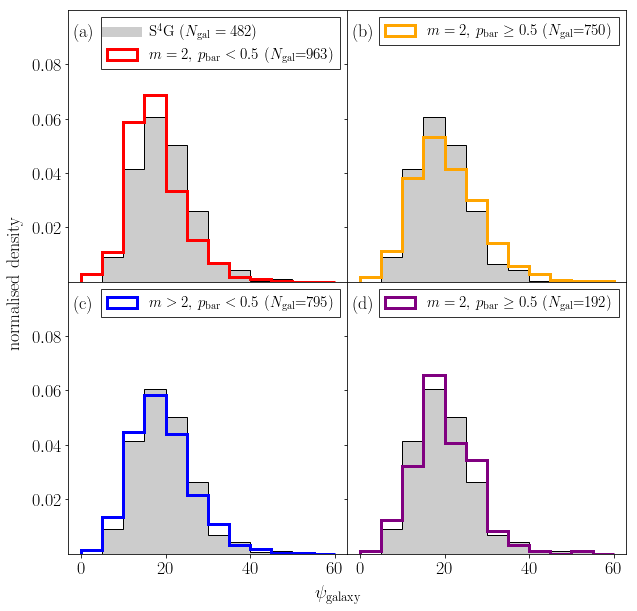

In [35]:
fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
axarr = axarr.ravel()
fig.subplots_adjust(hspace=0,wspace=0)

colors = ('red','orange','blue','purple')
classlabels = ('$m=2$, $p_\mathrm{bar}<0.5$',
               '$m=2$, $p_\mathrm{bar} \geq 0.5$',
               '$m>2$, $p_\mathrm{bar}<0.5$',
               '$m=2$, $p_\mathrm{bar} \geq 0.5$')
letters = 'abcd'

bins = np.linspace(0,60,13)

###############################

_ = axarr[0].plot([],[],color='k',alpha=0.2,lw=10,
            label='S$^4$G ($N_\mathrm{{gal}}={}$)'.format(len(s4g_psi))) 

for c, (ax, color) in enumerate(zip(axarr,colors)):
    in_class = np.all([sparcfire_sample_ok,gz2_stats['plot_class'] == c+1],
                      axis=0)
    psi_c = sparcfire_matched['P_wtd_avg'][in_class]
    _ = ax.hist(s4g_psi,bins,normed=True,color='k',alpha=0.2)
    _ = ax.hist(s4g_psi,bins,normed=True,color='k',histtype='step')
    c_label = classlabels[c] + ' ($N_\mathrm{{gal}}$={})'.format(in_class.sum())
    _ = ax.hist(psi_c,bins,normed=True,color=color,histtype='step',lw=3,
                label=c_label)
    ax.legend(loc='upper right',fancybox=False,edgecolor='k',fontsize=15)
    _ = ax.text(0.02,0.95,'({})'.format(letters[c]),
                transform=ax.transAxes,ha='left',va='top')

_ = ax.set_ylim(0,0.1)   
_ = fig.text(0.5, 0.06, '$\psi_\mathrm{galaxy}$', ha='center')
_ = fig.text(0.04, 0.5, 'normalised density', va='center', rotation='vertical')

_ = fig.savefig('paper_figures/pitch_angle_histograms.pdf')

In [38]:
print('S4G:')
print(np.percentile(s4g_psi,(16,50,84)))

print('all galaxies:')
print(np.percentile(sparcfire_matched['P_wtd_avg'][sparcfire_sample_ok],
      (16,50,84)))

S4G:
[ 13.498668  18.96335   25.733684]
all galaxies:
[ 12.29290436  18.07978249  26.23546707]


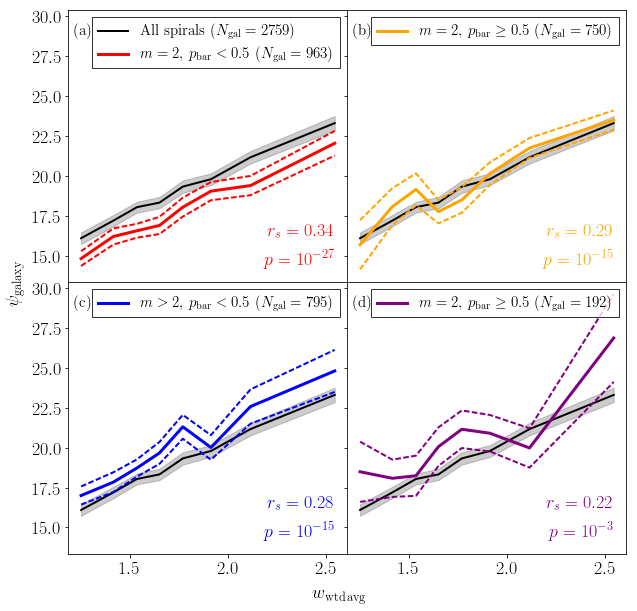

In [64]:
from bin_statistics import assign_bins
from xy_plots import x_vs_y

fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
axarr = axarr.ravel()
fig.subplots_adjust(hspace=0,wspace=0)

colors = ('red','orange','blue','purple')
classlabels = ('$m=2$, $p_\mathrm{bar}<0.5$',
               '$m=2$, $p_\mathrm{bar} \geq 0.5$',
               '$m>2$, $p_\mathrm{bar}<0.5$',
               '$m=2$, $p_\mathrm{bar} \geq 0.5$')
letters = 'abcd'

###############################
sample_bins = assign_bins(gz2_stats['w_wtd_avg'][sparcfire_sample_ok],
                          equal_N=True,N_bins=8)
galaxy_bins = np.zeros(len(gz2_stats))
galaxy_bins[sparcfire_sample_ok] = sample_bins

xy_all = x_vs_y(gz2_stats['w_wtd_avg'][sparcfire_sample_ok],
                sparcfire_matched['P_wtd_avg'][sparcfire_sample_ok])
xy_all = xy_all.continuous_vs_continuous_binned(bin_assignments=sample_bins)

axarr[0].plot([],[],color='k',lw=2,
    label='All spirals ($N_\mathrm{{gal}}={}$)'.format(sparcfire_sample_ok.sum()))

for c, (ax, color, label) in enumerate(zip(axarr,colors,classlabels)):
    xy_all.line_plot(ax,color='k',lw=2)
    xy_all.error_plot(ax,color='k',style='filled',alpha=0.2)
    
    in_class = np.all([gz2_stats['plot_class'] == c+1,sparcfire_sample_ok],
                      axis=0)
    class_bins = galaxy_bins[in_class]
    
    xy_label = label + ' ($N_\mathrm{{gal}}={}$)'.format(in_class.sum())
    xy = x_vs_y(gz2_stats['w_wtd_avg'][in_class],
                sparcfire_matched['P_wtd_avg'][in_class])
    xy = xy.continuous_vs_continuous_binned(bin_assignments=class_bins)
    xy.x_table = xy_all.x_table # for plotting
    xy.line_plot(ax,color=color,lw=3,label=xy_label)
    xy.error_plot(ax,style='lined',linestyle='dashed',lw=2,color=color)
    xy.spearmanr(ax,location='lower right',color=color,spacing=0.1)
    ax.legend(loc='upper right',fontsize=15,fancybox=False,edgecolor='k')
    ax.text(0.02,0.95,'({})'.format(letters[c]),fontsize=15,
            transform=ax.transAxes,va='top',ha='left')

_ = fig.text(0.5, 0.06,'$w_\mathrm{wtd \, avg}$', ha='center')
_ = fig.text(0.04, 0.5,r'$\psi_\mathrm{galaxy}$', va='center', rotation='vertical')

#fig.savefig('../paper_figures/w_wtd_avg_vs_P.pdf')

In [65]:
print(xy_all.spearmanr(None,plot=False,printout=True))

$r_s = 0.31$ $p = 10^{-60}$
None


#### Next task: compare spiral arm number and pitch angle?

Here, we shall use the M*-matched sample

In [106]:
masks = Table.read('fits/mass_masks_matched.fits')

bar_10 = np.all([gz2_stats['p_bar'] < 1.1,
                 sparcfire_sample_ok],axis=0)
mass_matched = np.any([masks[c] for c in ['m=1,b<1','m=2,b<1','m=3,b<1',
                                          'm=4,b<1','m=5+,b<1']],axis=0)
bar_10_matched = np.all([bar_10,mass_matched],axis=0)
print(bar_10.sum(),bar_10_matched.sum())
##################
bar_05 = np.all([gz2_stats['p_bar'] < 0.5,
                 sparcfire_sample_ok],axis=0)
mass_matched = np.any([masks[c] for c in ['m=1,b<0.5','m=2,b<0.5','m=3,b<0.5',
                                          'm=4,b<0.5','m=5+,b<0.5']],axis=0)
bar_05_matched = np.all([bar_05,mass_matched],axis=0)
print(bar_05.sum(),bar_05_matched.sum())
##################
bar_02 = np.all([gz2_stats['p_bar'] < 0.2,
                 sparcfire_sample_ok],axis=0)
mass_matched = np.any([masks[c] for c in ['m=1,b<0.2','m=2,b<0.2','m=3,b<0.2',
                                          'm=4,b<0.2','m=5+,b<0.2']],axis=0)
bar_02_matched = np.all([bar_02,mass_matched],axis=0)
print(bar_02.sum(),bar_02_matched.sum())

2759 2176
1804 1134
982 556


In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(10,4),sharex='row',sharey='row')


#fig = plt.figure()
#fig, axarr = plt.subplots(3,1,figsize=(10,15),sharex=True,sharey=True)

markers = ('o','s','^')
ticklabels = ('1','2','3','4','5+')
xys = []
for mask, label, ax, color, marker in zip([bar_10,bar_05,bar_02],classlabels,axarr,colors,markers):
    xy = x_vs_y(galaxy_level_data['m'][mask],
                galaxy_level_data['P_wtd_avg'][mask])
    xy = xy.discrete_vs_continuous_binned()
    xy_label = label + '\n ($N_\mathrm{{gal}}$={})'.format(mask.sum())
    xy.error_plot(ax,color=color,style='errorbar',marker=marker,
                  markersize=10,lw=3,capsize=3,capthick=3,label=xy_label)
    #xy.spearmanr(ax,location='lower right',spacing=0.1)
    ax.legend(loc='lower right',fontsize=15,fancybox=False,edgecolor='k')
    _ = ax.set_xlabel('$m$')
    xys.append(xy)
    
_ = axarr[0].set_xlim(0.5,5.5)
_ = axarr[0].set_xticks([1,2,3,4,5])
_ = axarr[0].set_xticklabels(ticklabels)
_ = axarr[0].set_ylabel(r'$\psi_\mathrm{galaxy}$')

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)

#fig.savefig('../paper_figures/m_vs_P.pdf')

In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(10,4),sharex='row',sharey='row')

classlabels = ('All',r'$p_\mathrm{bar}<0.5$',r'$p_\mathrm{bar}<0.2$')
colors = ('red','orangered','orange')

bar_10 = np.all([galaxy_level_data['p_bar'] < 1.1,
                 galaxy_level_data['has_good_arc'],
                 ml_data_matched['mass_matched_1']],axis=0)
bar_05 = np.all([galaxy_level_data['p_bar'] < 0.5,
                 galaxy_level_data['has_good_arc'],
                 ml_data_matched['mass_matched_2']],axis=0)
bar_02 = np.all([galaxy_level_data['p_bar'] < 0.2,
                 galaxy_level_data['has_good_arc'],
                 ml_data_matched['mass_matched_3']],axis=0)
masks = (bar_10,bar_05,bar_02)

for mask, label, ax, color in zip(masks,classlabels,axarr,colors):
    xy = x_vs_y(galaxy_level_data['m_wtd_avg'][mask],
                galaxy_level_data['P_wtd_avg'][mask])
    xy = xy.continuous_vs_continuous_binned(bins=10,equal_N=False)
    xy_label = label + ' \n ($N_\mathrm{{gal}}$={})'.format(mask.sum())
    xy.line_plot(ax,color=color,lw=2,label=xy_label)
    xy.error_plot(ax,color=color,alpha=0.2)
    xy.spearmanr(ax,location='upper left',spacing=0.1,fontsize=15)
    ax.legend(loc='lower right',fontsize=15,fancybox=False,edgecolor='k')
    _ = ax.set_xlabel('$m_\mathrm{wtd \, avg}$')
    
_ = axarr[0].set_xlim(1,5)
_ = axarr[0].set_xticks([2,3,4])
_ = axarr[0].set_ylabel(r'$\psi_\mathrm{galaxy}$')

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)

fig.savefig('../paper_figures/m_wtd_avg_vs_P.pdf')

In [ ]:
for b in range(3):

    print(xys[b].y_table['mean'],
          xys[b].y_table['mean']-xys[b].y_table['mean-1sigma'])

#### Final task: how does the presence of a bar affect the spiral arm pitch angle?

In [ ]:
fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)

galaxy_bins = assign_bins(good_galaxies['p_bar'],equal_N=False,N_bins=8)

m_2 = good_galaxies['m'] == 2
xy_all = x_vs_y(good_galaxies['p_bar'],good_galaxies['P_wtd_avg'])
xy_all = xy_all.continuous_vs_continuous_binned(bin_assignments=galaxy_bins)
xy_all_label='All ($N_\mathrm{{gal}}$={})'.format(len(good_galaxies))
xy_all.line_plot(ax,color='b',label=xy_all_label)
xy_all.error_plot(ax,color='b',alpha=0.2,style='filled')
xy_all.spearmanr(ax,color='b',location='lower right',y_offset=0.2)


xy_m_2 = x_vs_y(good_galaxies['p_bar'][m_2],good_galaxies['P_wtd_avg'][m_2])
xy_m_2 = xy_m_2.continuous_vs_continuous_binned(bin_assignments=galaxy_bins[m_2])
xy_m_2_label='$m=2$ only ($N_\mathrm{{gal}}$={})'.format(m_2.sum())
xy_m_2.line_plot(ax,color='red',lw=3,label=xy_m_2_label)
xy_m_2.error_plot(ax,color='red',style='lined',linestyle='dashed',lw=2)
xy_m_2.spearmanr(ax,color='r',location='lower right')

_ = ax.legend(loc='upper left',fontsize=15,fancybox=False,edgecolor='k')

_ = ax.set_xlabel('$p_\mathrm{bar}$')
_ = ax.set_ylabel('$\psi_\mathrm{galaxy}$')

fig.savefig('../paper_figures/p_bar_vs_P.pdf')